<a href="https://colab.research.google.com/github/aviax1/bark_detector/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**dependencies**

In [ ]:
!pip install wandb

In [6]:
import torch,wandb,os,warnings,csv
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from tensorflow.keras.datasets import mnist
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**get data**

In [ ]:
!git clone https://github.com/aviax1/bark_detector/

In [33]:
pd.plotting.register_matplotlib_converters()
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def read_fv():
    size=8732
    X_ = []
    Y = []
    i = 0
    with open('bark_detector/feature_vector.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in spamreader:
            if(i > 0):
                rw=row[0].split(",")
                fv=rw[2:]
                temp = np.array(fv)
                fv = temp.transpose()
                X_.append(fv)
                Y.append(int(rw[1]))
            i+=1
    X = np.empty([size, 128])
    for i in range(size):
        X[i] = (X_[i])
    #Y = to_categorical(Y)
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state = 1)
    xtrain = xtrain.reshape(6549, 128, 1)
    xtest = xtest.reshape(2183,128, 1)
    return xtrain, xtest, np.array(ytrain), np.array(ytest)

**load data**

In [35]:
(xtrain2,ytrain2), (xtest2,ytest2) = mnist.load_data() #old data

xtrain, xtest, ytrain, ytest=read_fv() # new data
num_epochs=1000        #
batch_size = 64        #
image_size=128         #
hidden_size=64         #
lv_size = 16           # Latent Variable 
learning_rate=1e-5     #
cret = nn.MSELoss()    # criterion
warnings.filterwarnings('ignore')

**build model**

In [36]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, hidden_size), 
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
             nn.ReLU(True), nn.Linear(hidden_size, lv_size))
        self.decoder = nn.Sequential(
            nn.Linear(lv_size, hidden_size),nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),nn.ReLU(True),
             nn.Linear(hidden_size, image_size), nn.Tanh())

    def forward(self, x):
        return self.decoder(self.encoder(x))

**model setting**

In [38]:
model = autoencoder()
tmodel=autoencoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

class DigitDataSet(Dataset):
  def __init__(self, dataset):
      self.dataset = dataset
      self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      return self.transform( self.dataset[idx,:,:])

**classsifcation by train models**

In [39]:
def model_name(digit):
  return './ae_'+str(digit)+'.pth'

def get_prediction(data=xtest):
  nn=len(data)
  dataloader = DataLoader(DigitDataSet(data), batch_size=nn,shuffle=0 , num_workers=4)
  diff = np.zeros( (nn,10),dtype=np.float32 )
  for i in range(10):
    for data in dataloader:
      input_imgs = data
      imgs = Variable(input_imgs.view(input_imgs.size(0), -1))
      tmodel.load_state_dict(torch.load(model_name(i)))
      tmodel.eval()
      output_imgs = tmodel(imgs)
      for i2 in range(len( output_imgs[:,0])):
        im_pred=output_imgs.detach().numpy()[i2,:]
        im_org=imgs.numpy()[i2,:]
        difmat=np.abs(im_pred.reshape(128,1)-im_org.reshape(128,1))
        diff[i2,i]=np.sum( np.sum( difmat ))
  return np.argmin(diff, axis=1)


def testmodel(): 
  nn=len(ytest)
  min_index =get_prediction()
  seccess =  min_index == ytest
  counts, bins = np.histogram(ytest[ min_index != ytest ])
  plt.hist(bins[:-1], bins, weights=counts)
  plt.title("error by digit")
  plt.show()
  accurcy =int(10000*np.sum(seccess))/(nn*100)
  error_rate = int(10000*np.sum(min_index != ytest))/(nn*100)
  print(str(accurcy) + "% accuracy or "+str(error_rate)+"% error rate")
  return counts, bins ,len(ytest[min_index != ytest]) , len(ytest)

**train method**

In [50]:
def save_model(digit,model):
  mn=model_name(digit)
  torch.save(model.state_dict(),mn )
  wandb.save(mn)
  print("save model "+ mn)

def load_model_ifexist(digit,model):
  mn=model_name(digit)
  if os.path.isfile(mn):
    model.load_state_dict(torch.load(mn))
    model.eval()
  return model

def train_by_digit(by_digit,model,ne=num_epochs,opt=optimizer):
  model=load_model_ifexist( by_digit,model)
  wandb.init()
  print("*****\nstart traning Model for digit " +str(by_digit) +"\n")
  dataloader = DataLoader(DigitDataSet(xtrain[ytrain==by_digit]), batch_size=batch_size,shuffle=True, num_workers=6)
  minloss=100000000
  for epoch in range(ne):
    run=  epoch%25==0
    run2= epoch%125==0 and epoch >0
    for data in dataloader:
      
      imgs = Variable(data.view(data.size(0), -1))
      imgs=imgs.float()
      output_imgs = model(imgs)
      loss = cret(output_imgs, imgs)
      
      if minloss!=100000000:
        opt.zero_grad()
        loss.backward()
        opt.step()
      if run:
        run=0
        im=data[0,0,:,:].reshape(128,1)
        pred=model(imgs).detach().numpy()[0,:].reshape(128,1)
        wandb.log({"img": [wandb.Image(pred, caption="preidciton"),wandb.Image(im, caption="original")]})
      if run2:
        run2=0
        save_model(by_digit,model)
        testmodel()
    newlost = float(loss.data ) 
    if newlost < minloss:
        if minloss!=100000000:
          save_model(by_digit,model)
        minloss=newlost
    print('epoch [{}/{}], loss:{:.4f}' .format(epoch + 1, ne, loss.data))
    wandb.log({"loss": loss.data})
  
  print("\nfinish traning Model Number " +str(by_digit) +"\n*****\n")

train_by_digit(0,model,50)

_runtime,6
_timestamp,1617137455
_step,12
loss,207.92497


_runtime,▁▁▁▃▃▃▆▆▆▆███
_timestamp,▁▁▁▃▃▃▆▆▆▆███
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▃▃▅▂▅▄▃██▆▁▂


*****
start traning Model for digit 0

epoch [1/50], loss:130.9523
epoch [2/50], loss:469.5811
epoch [3/50], loss:359.4415
epoch [4/50], loss:568.6316
epoch [5/50], loss:711.3348
epoch [6/50], loss:338.9812
epoch [7/50], loss:373.5551
epoch [8/50], loss:490.0018
epoch [9/50], loss:151.6236
epoch [10/50], loss:447.7233
epoch [11/50], loss:300.0703
epoch [12/50], loss:138.7274
epoch [13/50], loss:263.1299
epoch [14/50], loss:264.6154
epoch [15/50], loss:357.9136
epoch [16/50], loss:329.8198
epoch [17/50], loss:395.6107
epoch [18/50], loss:528.3433
epoch [19/50], loss:410.1742
epoch [20/50], loss:403.1489
epoch [21/50], loss:326.4267
epoch [22/50], loss:527.1936
epoch [23/50], loss:238.1804
epoch [24/50], loss:322.5916
epoch [25/50], loss:491.0786
epoch [26/50], loss:281.9354
epoch [27/50], loss:270.6360
epoch [28/50], loss:437.1325
epoch [29/50], loss:389.8714
epoch [30/50], loss:246.9763
epoch [31/50], loss:511.9742
epoch [32/50], loss:464.9848
epoch [33/50], loss:174.2718
epoch [34/50]

**train new model**

In [ ]:
for by_digit in range(10):
  train_by_digit(by_digit,model,12)
  train_by_digit(by_digit,model,12)
_,_,_,_=testmodel()

_runtime,17
_timestamp,1617137487
_step,51
loss,661.48999


_runtime,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▅▄▇▄▄▆▁▃▁▃▃▄▄▆▅▄▆▂▄▃▃▅▄▆▅▂▅▄▃▆▂▄▃▂▆▆▄▄█


*****
start traning Model for digit 0

epoch [1/12], loss:218.3069
epoch [2/12], loss:386.3517
epoch [3/12], loss:292.4919
epoch [4/12], loss:227.6579
epoch [5/12], loss:245.2583
epoch [6/12], loss:316.0211
epoch [7/12], loss:577.5516
epoch [8/12], loss:391.1845
epoch [9/12], loss:304.1765
epoch [10/12], loss:356.5726
epoch [11/12], loss:884.3891
epoch [12/12], loss:414.0623

finish traning Model Number 0
*****



_runtime,6
_timestamp,1617137521
_step,12
loss,414.06226


_runtime,▁▁▃▃▃▃▆▆▆████
_timestamp,▁▁▃▃▃▃▆▆▆████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▁▃▂▁▁▂▅▃▂▂█▃


*****
start traning Model for digit 0

epoch [1/12], loss:154.5140
epoch [2/12], loss:254.9016
epoch [3/12], loss:508.0553
epoch [4/12], loss:490.0901
epoch [5/12], loss:481.8800
epoch [6/12], loss:365.5082
epoch [7/12], loss:477.0193
epoch [8/12], loss:371.8691
epoch [9/12], loss:283.3579
epoch [10/12], loss:562.0080
epoch [11/12], loss:336.0625
epoch [12/12], loss:450.2323

finish traning Model Number 0
*****



_runtime,6
_timestamp,1617137531
_step,12
loss,450.2323


_runtime,▁▁▁▃▃▃▆▆▆▆███
_timestamp,▁▁▁▃▃▃▆▆▆▆███
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▁▃▇▇▇▅▇▅▃█▄▆


*****
start traning Model for digit 1

epoch [1/12], loss:1963.6805
epoch [2/12], loss:9158.0781
save model ./ae_1.pth
epoch [3/12], loss:488.4867
epoch [4/12], loss:8692.8506
epoch [5/12], loss:1032.1417
epoch [6/12], loss:811.1836
epoch [7/12], loss:836.6710
epoch [8/12], loss:1086.0624
epoch [9/12], loss:8923.6631
epoch [10/12], loss:1300.4973
epoch [11/12], loss:708.3926
epoch [12/12], loss:821.9437

finish traning Model Number 1
*****



_runtime,5
_timestamp,1617137540
_step,12
loss,821.94366


_runtime,▁▁▁▁▅▅▅▅█████
_timestamp,▁▁▁▁▅▅▅▅█████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▂█▁█▁▁▁▁█▂▁▁


*****
start traning Model for digit 1

epoch [1/12], loss:426.2407
epoch [2/12], loss:836.9080
epoch [3/12], loss:741.3648
epoch [4/12], loss:1042.6661
epoch [5/12], loss:1102.5956
epoch [6/12], loss:1046.9532
epoch [7/12], loss:872.3277
epoch [8/12], loss:1438.2245
epoch [9/12], loss:1194.3973
epoch [10/12], loss:477.6022
epoch [11/12], loss:922.8427
epoch [12/12], loss:9755.7168

finish traning Model Number 1
*****



_runtime,6
_timestamp,1617137550
_step,12
loss,9755.7168


_runtime,▁▁▁▃▃▃▃▃▆▆▆▆█
_timestamp,▁▁▁▃▃▃▃▃▆▆▆▆█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▁▁▁▁▂▁▁▂▂▁▁█


*****
start traning Model for digit 2

epoch [1/12], loss:33.6307
epoch [2/12], loss:87.9153
save model ./ae_2.pth
epoch [3/12], loss:10.8590
epoch [4/12], loss:358.7920
epoch [5/12], loss:32.8613
epoch [6/12], loss:64.0584
epoch [7/12], loss:22.2249
epoch [8/12], loss:400.1011
epoch [9/12], loss:288.3499
epoch [10/12], loss:48.1764
epoch [11/12], loss:465.3177
epoch [12/12], loss:431.4943

finish traning Model Number 2
*****



_runtime,7
_timestamp,1617137560
_step,12
loss,431.49429


_runtime,▁▁▃▃▃▅▅▅▅▆▆▆█
_timestamp,▁▁▃▃▃▅▅▅▅▆▆▆█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▁▂▁▆▁▂▁▇▅▂█▇


*****
start traning Model for digit 2

epoch [1/12], loss:78.7627
save model ./ae_2.pth
epoch [2/12], loss:28.0409
epoch [3/12], loss:31.3755
epoch [4/12], loss:108.4196
epoch [5/12], loss:147.8941
epoch [6/12], loss:74.0817
epoch [7/12], loss:60.4117
epoch [8/12], loss:79.6085
epoch [9/12], loss:154.3287
epoch [10/12], loss:226.8050
epoch [11/12], loss:283.5294
epoch [12/12], loss:945.3611

finish traning Model Number 2
*****



_runtime,7
_timestamp,1617137570
_step,12
loss,945.36115


_runtime,▁▁▃▃▃▃▅▅▅▆▆▆█
_timestamp,▁▁▃▃▃▃▅▅▅▆▆▆█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▁▁▁▂▂▁▁▁▂▃▃█


*****
start traning Model for digit 3

epoch [1/12], loss:6579.3193
save model ./ae_3.pth
epoch [2/12], loss:281.4354
epoch [3/12], loss:2332.9238
epoch [4/12], loss:4027.3843
epoch [5/12], loss:3784.8252
epoch [6/12], loss:694.3206
epoch [7/12], loss:4628.6611
epoch [8/12], loss:1019.4453
epoch [9/12], loss:5763.1445
epoch [10/12], loss:3475.2117
epoch [11/12], loss:833.5611
epoch [12/12], loss:7325.0005

finish traning Model Number 3
*****



_runtime,7
_timestamp,1617137580
_step,12
loss,7325.00049


_runtime,▁▁▃▃▃▃▅▅▅▆▆▆█
_timestamp,▁▁▃▃▃▃▅▅▅▆▆▆█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▇▁▃▅▄▁▅▂▆▄▂█


*****
start traning Model for digit 3

epoch [1/12], loss:1657.0604
epoch [2/12], loss:1659.1150
save model ./ae_3.pth
epoch [3/12], loss:449.2666
epoch [4/12], loss:3044.2107
epoch [5/12], loss:3216.7988
epoch [6/12], loss:548.8209
epoch [7/12], loss:2168.6301
epoch [8/12], loss:4311.1006
epoch [9/12], loss:6475.7271
epoch [10/12], loss:2134.8960
save model ./ae_3.pth
epoch [11/12], loss:326.2840
epoch [12/12], loss:533.3682

finish traning Model Number 3
*****



_runtime,7
_timestamp,1617137590
_step,12
loss,533.36823


_runtime,▁▁▃▃▃▅▅▅▆▆▆██
_timestamp,▁▁▃▃▃▅▅▅▆▆▆██
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▃▃▁▄▄▁▃▆█▃▁▁


*****
start traning Model for digit 4

epoch [1/12], loss:58.8783
save model ./ae_4.pth
epoch [2/12], loss:27.6045
epoch [3/12], loss:64.5977
epoch [4/12], loss:746.9701
epoch [5/12], loss:3693.0732
epoch [6/12], loss:50.7774
epoch [7/12], loss:169.6004
epoch [8/12], loss:71.2395
epoch [9/12], loss:229.8175
epoch [10/12], loss:68.3009
epoch [11/12], loss:55.9026
epoch [12/12], loss:972.7346

finish traning Model Number 4
*****



**or used our train model**

In [ ]:
!git clone https://github.com/aviax1/AE1/
!unzip ./AE1/models.zip -d ./
!rm -rf ./AE1

**finaly test model**

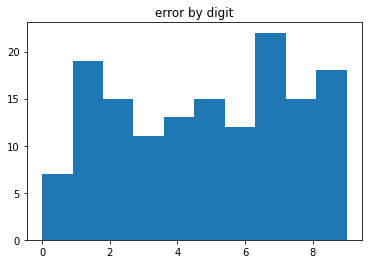

98.53% accuracy or 1.47% error rate


In [ ]:
_,_,_,_=testmodel()

**retrain the model**

In [ ]:
traget_error=0.005
error = 1
while  error > traget_error:
  counts,b,fail,total=testmodel()
  error = float(fail/total)
  if error > traget_error:
    train_by_digit(np.argmax(counts),model,30, torch.optim.Adam(model.parameters(), lr=1e-3) )

**kaggle**

In [ ]:
!git clone https://github.com/aviax1/AE1/
!unzip ./AE1/kaggle.zip -d ./
!rm -rf ./AE1

In [ ]:
inputs_test=pd.read_csv('./test.csv')
inputs_test=np.array(inputs_test,dtype=np.float32)
inputs_test=inputs_test.reshape(inputs_test.shape[0],28,28)/255
y=get_prediction(inputs_test)
imageid=1
with open('submission.csv', 'w', newline='') as csvfile:
  spamwriter = csv.writer(csvfile, delimiter=' ',    quotechar='|', quoting=csv.QUOTE_MINIMAL)
  spamwriter.writerow(['ImageId,Label'])
  for yi in y:
    spamwriter.writerow([str(imageid) +','+str( yi)])
    imageid+=1
#99.714% accuracy